_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c4_interpolated_2300_100.csv")
training_set = data.iloc[:, 1]
training_set

0       88.600000
1       88.409524
2       88.219048
3       88.028571
4       87.838095
          ...    
2395    56.278951
2396    56.266653
2397    56.254355
2398    56.242058
2399    56.229760
Name: C4, Length: 2400, dtype: float64

In [6]:
test = training_set.tail(100)
test
training_set = training_set.head(2300)
training_set

0       88.600000
1       88.409524
2       88.219048
3       88.028571
4       87.838095
          ...    
2295     0.482198
2296     0.000000
2297     0.000000
2298     0.000000
2299     0.000000
Name: C4, Length: 2300, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,88.600000,0.000298
1,88.409524,0.000298
2,88.219048,0.000297
3,88.028571,0.000297
4,87.838095,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

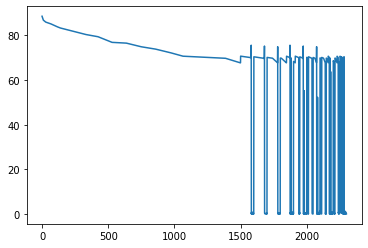

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

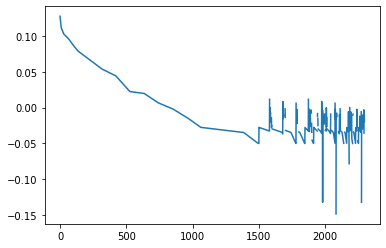

In [11]:
import numpy as np
c0 = 86.6856  # Value for C0
K0 = -0.0008  # Value for K0
K1 = -0.0002  # Value for K1
a = 0.0000    # Value for a
b = 0.0128    # Value for b
c = -2.3003    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 350, n_out = 100)


cols_to_drop = []
for i in range(2, 351):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-350)  var1(t-349)  var1(t-348)  var1(t-347)  var1(t-346)  \
350    88.600000    88.409524    88.219048    88.028571    87.838095   
351    88.409524    88.219048    88.028571    87.838095    87.647619   
352    88.219048    88.028571    87.838095    87.647619    87.457143   
353    88.028571    87.838095    87.647619    87.457143    87.266667   
354    87.838095    87.647619    87.457143    87.266667    87.076190   

     var1(t-345)  var1(t-344)  var1(t-343)  var1(t-342)  var1(t-341)  ...  \
350    87.647619    87.457143    87.266667    87.076190    86.896218  ...   
351    87.457143    87.266667    87.076190    86.896218    86.845798  ...   
352    87.266667    87.076190    86.896218    86.845798    86.795378  ...   
353    87.076190    86.896218    86.845798    86.795378    86.744958  ...   
354    86.896218    86.845798    86.795378    86.744958    86.694538  ...   

     var1(t+95)  var2(t+95)  var1(t+96)  var2(t+96)  var1(t+97)  var2(t+97)  \
350   78.880345    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-300:]
trainX = train[:,:-300]

In [16]:
forecasty = forecast[:,-300:]
forecastX = forecast[:,:-300]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1850, 1, 251) (1850, 300) (1, 1, 251)


In [18]:
C0 = tf.Variable(86.6856, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0008, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0002, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0128, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(-2.3003, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
24/24 [==============================] - 3s 37ms/step - loss: 5130.6177 - val_loss: 3194.6213
Epoch 2/500
24/24 [==============================] - 0s 4ms/step - loss: 4847.2461 - val_loss: 3021.7754
Epoch 3/500
24/24 [==============================] - 0s 4ms/step - loss: 4723.2461 - val_loss: 2956.0310
Epoch 4/500
24/24 [==============================] - 0s 4ms/step - loss: 4625.7114 - val_loss: 2893.5710
Epoch 5/500
24/24 [==============================] - 0s 4ms/step - loss: 4531.7710 - val_loss: 2832.7031
Epoch 6/500
24/24 [==============================] - 0s 4ms/step - loss: 4440.5195 - val_loss: 2775.8035
Epoch 7/500
24/24 [==============================] - 0s 4ms/step - loss: 4351.4961 - val_loss: 2720.4587
Epoch 8/500
24/24 [==============================] - 0s 4ms/step - loss: 4264.3545 - val_loss: 2666.5088
Epoch 9/500
24/24 [==============================] - 0s 4ms/step - loss: 4178.9121 - val_loss: 2613.8562
Epoch 10/500
24/24 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 385ms/step


In [20]:
forecastX.shape

(1, 1, 251)

In [21]:
forecast_without_mc.shape

(1, 251)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 311)

In [24]:
fforecast = inv_yhat_without_mc[:,-300:]

In [25]:
fforecast.shape

(1, 300)

In [26]:
final_forecast = fforecast[:,0:300:3]

In [27]:
fforecast.shape

(1, 300)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[7.03326333e+01, 7.02576330e+01, 7.01820028e+01, 7.01063726e+01,
        7.56191101e+01, 0.00000000e+00, 9.78886190e-02, 2.32655033e-01,
        1.62875891e-01, 3.43400270e-01, 5.80880420e-02, 7.16635060e-02,
        5.68655014e-01, 6.83504202e+01, 6.81823529e+01, 6.80142857e+01,
        6.78462185e+01, 6.77348109e+01, 7.06525910e+01, 7.05769608e+01,
        7.05013305e+01, 7.04257003e+01, 7.03500700e+01, 7.02744398e+01,
        7.01988095e+01, 7.01231793e+01, 7.00475490e+01, 1.77199480e-01,
        6.68463530e-01, 7.03808823e+01, 7.03052521e+01, 7.02296219e+01,
        7.01539916e+01, 7.00783613e+01, 7.00027311e+01, 6.99271008e+01,
        6.98514706e+01, 6.96389356e+01, 2.48600350e-01, 1.49832010e-01,
        8.27042500e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.87215070e-01, 0.00000000e+00, 0.00000000e+00, 7.01399860e+01,
        7.00643557e+01, 6.12748000e-03, 3.29938740e-01, 7.03976891e+01,
        7.03220588e+01, 7.02464286e+01, 7.01707983e+01, 7.009516

In [30]:
final_forecast.shape

(1, 100)

In [31]:
test.shape

(100,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([57.44722279, 57.43492519, 57.42262759, 57.41032999, 57.39803238,
       57.38573478, 57.37343718, 57.36113958, 57.34884198, 57.33654437,
       57.32424677, 57.31194917, 57.29965157, 57.28735397, 57.27505636,
       57.26275876, 57.25046116, 57.23816356, 57.22586596, 57.21356835,
       57.20127075, 57.18897315, 57.17667555, 57.16437795, 57.15208034,
       57.13978274, 57.12748514, 57.11518754, 57.10288994, 57.09059233,
       57.07829473, 57.06599713, 57.05369953, 57.04140193, 57.02910432,
       57.01680672, 57.00450912, 56.99221152, 56.97991392, 56.96761631,
       56.95531871, 56.94302111, 56.93072351, 56.91842591, 56.9061283 ,
       56.8938307 , 56.8815331 , 56.8692355 , 56.8569379 , 56.8446403 ,
       56.83234269, 56.82004509, 56.80774749, 56.79544989, 56.78315229,
       56.77085468, 56.75855708, 56.74625948, 56.73396188, 56.72166428,
       56.70936667, 56.69706907, 56.68477147, 56.67247387, 56.66017627,
       56.64787866, 56.63558106, 56.62328346, 56.61098586, 56.59

In [34]:
test.shape

(100,)

In [35]:
final_forecast.shape

(100,)

In [36]:
test.shape

(100,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

41.39325655976586
35.13137048261038
